# Visualisierung eines Noise2Void-Runs

In diesem Notebook gibst du **einmalig** den Pfad zu deinem gespeicherten Run-Ordner an.  
Dann werden daraus automatisch geladen:
- die `config.py` (aus `used_source`),  
- dein U-Net-Modell mit dem Checkpoint `best.pt`,  
- Trainings- und Validierungs-Datasets,  
- und es werden exemplarisch je drei Beispiele aus Training und Validation geplottet.

# Parameter setzen:

In [1]:
import os
import sys

# — Stelle hier deinen Run-Ordner ein (z.B. …/trained_models/First_Test) —
run_dir = "../trained_models/Big_Lesion_normalized_LR30"    #_3Layers_ynetRank3 <-- anpassen

# GPU wählen
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # or whichever GPU you want

# Andere parameter automatisch laden

In [2]:
# ── Zelle 2: Run-Config & used_source in sys.path einfügen ──

import os
import sys
import importlib.util

# 1) Absoluter Pfad zum Run-Verzeichnis (aus Zelle 1)
run_dir = os.path.abspath(run_dir)

# 2) Pfad zum used_source-Snapshot
USED_SRC = os.path.join(run_dir, "used_source")

# 3) Ganz vorne in sys.path einfügen, damit alle Imports daraus gezogen werden
if USED_SRC not in sys.path:
    sys.path.insert(0, USED_SRC)

# (Optional) Projekt-Root als Fallback auf Position 1
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(1, PROJECT_ROOT)

# Debug: sys.path prüfen
print("⤷ sys.path[0:2] =", sys.path[:2])

# 4) Pfad zur Config im used_source-Ordner
config_path = os.path.join(USED_SRC, "config.py")

# 5) Dynamisch als Modul importieren
spec = importlib.util.spec_from_file_location("run_config", config_path)
run_config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(run_config)

# 6) Absoluten Pfad für checkpoint_dir anpassen (falls relativ)
if not os.path.isabs(run_config.checkpoint_dir):
    run_config.checkpoint_dir = os.path.join(PROJECT_ROOT, run_config.checkpoint_dir)

# 7) Werte ausgeben
print(f"RUN_NAME           = {run_config.RUN_NAME}")
print(f"Checkpoint-Ordner  = {run_config.checkpoint_dir}")


⤷ sys.path[0:2] = ['/workspace/Deuterium_Denosing/trained_models/Big_Lesion_normalized_LR30/used_source', '/workspace/Deuterium_Denosing']
RUN_NAME           = Big_Lesion_normalized_LR30
Checkpoint-Ordner  = /workspace/Deuterium_Denosing/trained_models/Big_Lesion_normalized_LR30/checkpoints


# Bibliotheken und Geräte

# Model laden

In [3]:
# --- Cell A: Device & Model --------------------------------------------------
import torch, os

# Device wählen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Verwendetes Device:", device)

# Modellklasse & Checkpoint-Name je nach TRAIN_METHOD
tm = run_config.TRAIN_METHOD.lower()
ud = run_config.UNET_DIM.lower()

if tm == "ynet_n2v":
    assert ud == "2d", "Y-Net ist nur für 2-D verfügbar"
    from models.ynet2d import YNet2D as NetClass
    ckpt_name = "best_ynet.pt"
    model = NetClass(
        in_ch_noisy  = run_config.in_channels_noisy,
        in_ch_lr     = run_config.in_channels_lr,
        out_channels = run_config.out_channels,
        features     = run_config.features
    ).to(device)

elif tm == "sup_lowrank":
    assert ud == "2d", "Supervised LowRank U-Net wurde nur für 2-D implementiert"
    from models.unet2d import UNet2D as NetClass
    ckpt_name = "best_unet_lowrank.pt"
    model = NetClass(
        in_channels  = run_config.in_channels,
        out_channels = run_config.out_channels,
        features     = run_config.features
    ).to(device)

else:
    if ud == "2d":
        from models.unet2d import UNet2D as NetClass
        ckpt_name = "last.pt"
        features = run_config.features
    else:  # ud == "3d"
        from models.unet3d import UNet3D as NetClass
        ckpt_name = "best3d.pt"
        features = run_config.features_3d  # ← hier die Änderung

    model = NetClass(
        in_channels  = run_config.in_channels,
        out_channels = run_config.out_channels,
        features     = features
    ).to(device)

# --- Checkpoint laden --------------------------------------------------------
ckpt_path = os.path.join(run_config.checkpoint_dir, ckpt_name)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()

print(f"✓ Modell geladen: {run_config.TRAIN_METHOD.upper()}-{run_config.UNET_DIM}  "
      f"({ckpt_name},  Epoch {ckpt.get('epoch','?')})")

Verwendetes Device: cuda
✓ Modell geladen: N2V-2d  (last.pt,  Epoch 72)


# Datasets & DataLoader

In [4]:
# ── Cell B + C: End-to-End-Inference & Post-Processing ──────────────────────
import numpy as np, torch, os
from itertools import product
from math import prod
from data.data_utils import load_and_preprocess_data, low_rank

# ---------------------------------------------------------------------------#
# 1) Validation-Daten laden
# ---------------------------------------------------------------------------#
data_val = load_and_preprocess_data(
    folder_names = run_config.val_data,#run_config.val_data ,#run_config.val_data, ['P07']
    base_path    = os.path.join(PROJECT_ROOT, "datasets"),
    fourier_axes = run_config.fourier_transform_axes
)

print(np.max(np.abs(data_val)))

data_gt = load_and_preprocess_data(
    folder_names = ['Simulated_Lesion_GT_double_normalized'],#'Simulated_Lesion_GT'  , Simulated_ground_truth'
    base_path    = os.path.join(PROJECT_ROOT, "datasets"),
    fourier_axes = run_config.fourier_transform_axes
)

if run_config.TRAIN_METHOD == "ynet" or "ynet_n2v":
    lowrank_val = low_rank(data_val.copy(), rank=run_config.lowrank_rank)

# ---------------------------------------------------------------------------#
# 2) Achsen-Definition
# ---------------------------------------------------------------------------#
spatial_axes = (run_config.image_axes if run_config.UNET_DIM == "2d"
                else run_config.volume_axes)            # (len==2) oder (len==3)
all_axes     = list(range(data_val.ndim))
other_axes   = [ax for ax in all_axes if ax not in spatial_axes]
ranges       = [range(data_val.shape[ax]) for ax in other_axes]

print(f"Spatial axes: {spatial_axes} | Other axes: {other_axes} "
      f"→ geplante Vorwärtspässe: {prod(len(r) for r in ranges)}")

# ---------------------------------------------------------------------------#
# 3) Output-Array anlegen
# ---------------------------------------------------------------------------#
out_data = np.zeros_like(data_val, dtype=np.complex64)

# ---------------------------------------------------------------------------#
# 4) Hilfs-Funktion
# ---------------------------------------------------------------------------#
def to_tensor(arr):          # arr shape (2,*spatial)
    return torch.from_numpy(arr)[None].to(device)

# ---------------------------------------------------------------------------#
# ---------------------------------------------------------------------------#
# 5) Inference
# ---------------------------------------------------------------------------#
model.eval()
with torch.no_grad():

    if run_config.UNET_DIM.lower() == "3d":
        # ─────────────────────────────── 3-D: drei Ansichten mitteln ───────────────────────────────
        axis_triplets = [(0, 3, 4), (1, 3, 4), (2,3,4)]   # x,f,T  | y,f,T | z,f,T
        out_sum  = np.zeros_like(data_val, dtype=np.complex64)
        vote_cnt = np.zeros_like(data_val, dtype=np.uint8)

        for spatial_axes in axis_triplets:
            all_axes   = list(range(data_val.ndim))
            other_axes = [ax for ax in all_axes if ax not in spatial_axes]
            ranges     = [range(data_val.shape[ax]) for ax in other_axes]

            for idx in product(*ranges):
                slicer = [slice(None) if ax in spatial_axes
                          else idx[other_axes.index(ax)]
                          for ax in all_axes]

                spec = data_val[tuple(slicer)]                  # (spatial,F,T) komplex
                img  = np.stack([spec.real, spec.imag], axis=0).astype(np.float32)
                pred = model(to_tensor(img)).squeeze(0).cpu().numpy()

                den = pred[0] + 1j * pred[1]
                out_sum [tuple(slicer)] += den
                vote_cnt[tuple(slicer)] += 1

        out_data = out_sum / np.where(vote_cnt == 0, 1, vote_cnt)
        print("✓ 3-D-Inference für alle drei Ansichten abgeschlossen und gemittelt")

    else:
        # ─────────────────────────────── 2-D: unverändert ───────────────────────────────
        spatial_axes = run_config.image_axes
        all_axes     = list(range(data_val.ndim))
        other_axes   = [ax for ax in all_axes if ax not in spatial_axes]
        ranges       = [range(data_val.shape[ax]) for ax in other_axes]

        for idx in product(*ranges):
            slicer = [slice(None) if ax in spatial_axes
                      else idx[other_axes.index(ax)]
                      for ax in all_axes]

            spec = data_val[tuple(slicer)]                      # komplex-Block
            img  = np.stack([spec.real, spec.imag], axis=0).astype(np.float32)

            if run_config.TRAIN_METHOD in ("ynet", "ynet_n2v"):
                spec_lr = lowrank_val[tuple(slicer)]
                img_lr  = np.stack([spec_lr.real, spec_lr.imag], axis=0).astype(np.float32)
                pred = model(to_tensor(img), to_tensor(img_lr)).squeeze(0).cpu().numpy()
            else:
                pred = model(to_tensor(img)).squeeze(0).cpu().numpy()

            den = pred[0] + 1j * pred[1]
            out_data[tuple(slicer)] = den

        print("✓ 2-D-Inference abgeschlossen")


# ---------------------------------------------------------------------------#
# 6) Post-Processing
# ---------------------------------------------------------------------------#
# Runs-Achse (letzte) ggf. entfernen

tgt_data = data_gt[..., 0] if data_gt.shape[-1] == 1 else data_gt#data_gt*Normierungs_Faktor_ground_truth/Normierungs_Faktor_noisy#data_val[..., 0] if out_data.shape[-1] == 1 else data_val

noisy_data = data_val[..., 0] if out_data.shape[-1] == 1 else data_val

out_data = out_data[..., 0] if out_data.shape[-1] == 1 else out_data

# Inverse FFT aus Frequenz-/Zeit-Domäne zurück in FID
axes = tuple(run_config.fourier_transform_axes)
out_data = np.fft.ifftn(np.fft.ifftshift(out_data, axes=axes), axes=axes)
noisy_data = np.fft.ifftn(np.fft.ifftshift(noisy_data, axes=axes), axes=axes)
tgt_data = np.fft.ifftn(np.fft.ifftshift(tgt_data, axes=axes), axes=axes)

# Low-Rank-Baseline (rein qualitativ)
rank_post = 8

baseline_data = low_rank(noisy_data, rank=rank_post)
#out_data = low_rank(out_data, rank=rank_post) 

# Gemeinsame Normierung (optional fürs Plotten)
# max_val = max(np.abs(out_data).max(),
#               np.abs(tgt_data).max(),
#               np.abs(baseline_data).max())
# out_data      /= np.abs(out_data).max()
# tgt_data      /= np.abs(tgt_data).max()
# baseline_data /= np.abs(baseline_data).max()

# FFT zurück in Spektralraum für Peaks
out_data_ft      = np.fft.fftshift(np.fft.fft(out_data, axis=3), axes=3)
tgt_data_ft      = np.fft.fftshift(np.fft.fft(tgt_data, axis=3), axes=3)
baseline_data_ft = np.fft.fftshift(np.fft.fft(baseline_data, axis=3), axes=3)
noisy_data_ft = np.fft.fftshift(np.fft.fft(noisy_data, axis=3), axes=3)

print("✓ Post-Processing fertig:")
print("  out_data      :", out_data.shape)
print("  tgt_data      :", tgt_data.shape)
print("  baseline_data :", baseline_data.shape)

17.088268327216735
Spatial axes: (3, 4) | Other axes: [0, 1, 2, 5] → geplante Vorwärtspässe: 10164
✓ 2-D-Inference abgeschlossen
✓ Post-Processing fertig:
  out_data      : (22, 22, 21, 120, 8)
  tgt_data      : (22, 22, 21, 120, 8)
  baseline_data : (22, 22, 21, 120, 8)


# check if model uses both paths

# Optional als matlab datei speichern

In [5]:
# from scipy.io import loadmat, savemat

# ### CAREFUL DISTINGUISH BETWEEN LESION AND NO LESION

# # Lade Par und mask aus der B0_1.mat-Datei
# b0_data = loadmat('../datasets/Archiv/Simulated_Lesion_GT/Lesion_120pts.mat')  #Simulated_Lesion_GT/Lesion_120pts.mat  Simulated_ground_truth/B0_1.mat
# par = b0_data['csi_data_lr']['Par'][0, 0]
# mask = b0_data['csi_data_lr']['mask'][0, 0]

# # Deine Datensätze
# data_dicts = {
#     'Lesion_LR8.mat': baseline_data,
#     'Lesion_noisy.mat': noisy_data,
#     'Lesion_deep.mat': out_data,
#     'Lesion_gt.mat': tgt_data
# }

# # Für jede Datei speichern
# for filename, data in data_dicts.items():
#     savemat(filename, {
#         'csi_data_lr': {
#             'Data': data,
#             'Par': par,
#             'mask': mask
#         }
#     })

# Compare FID

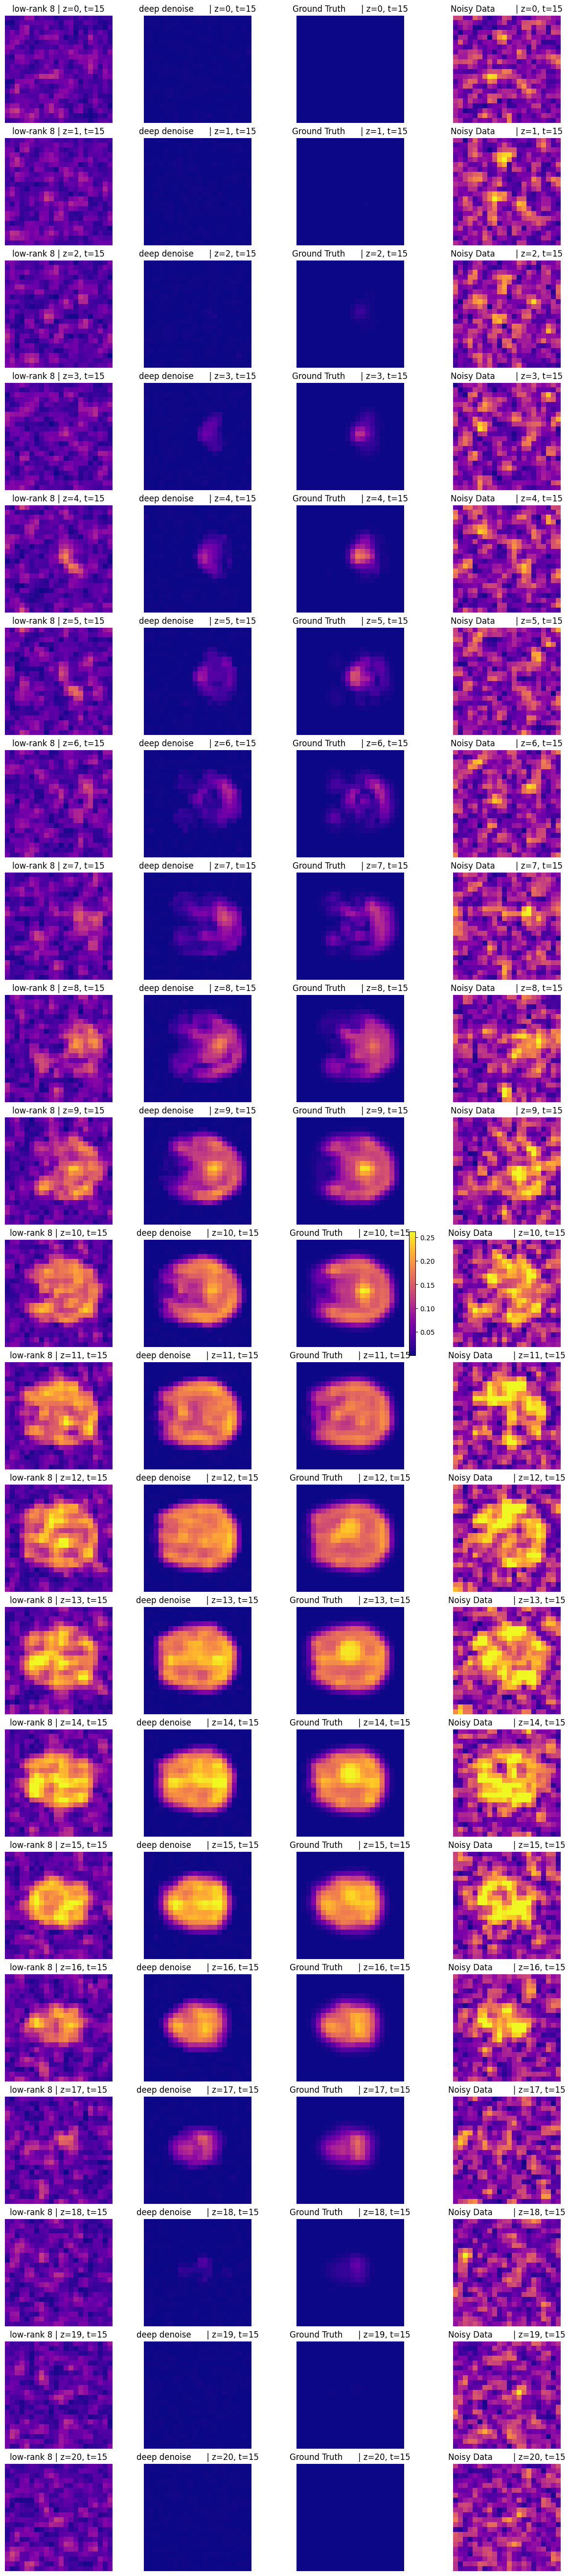

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ── Einstellungen -----------------------------------------------------------
t, T = 15, 7
n_slices = out_data.shape[2]

# ── 1) globales vmin/vmax nur aus der vorletzten Spalte (sl_in) berechnen ───
#    abs(tgt_data) über alle x,y,z
all_in = np.abs(tgt_data[:, :, :, t, T])
vmin = all_in.min()
vmax = all_in.max()

# ── 2) Figure mit 4 Spalten ────────────────────────────────────────────────
fig, axes = plt.subplots(
    n_slices, 4,
    figsize=(12, n_slices * 2.5),
    constrained_layout=True
)

for z in range(n_slices):
    # Slice‑Magnituden
    sl_lr    = np.abs(baseline_data[:, :, z, t, T])
    sl_deep  = np.abs(out_data     [:, :, z, t, T])
    sl_in    = np.abs(tgt_data     [:, :, z, t, T])
    sl_noisy = np.abs(noisy_data   [:, :, z, t, T])

    # je vier Bilder mit identischer Farbskala aus sl_in
    ax_lr, ax_deep, ax_in, ax_noisy = axes[z]
    im0 = ax_lr   .imshow(sl_lr,    cmap='plasma', vmin=vmin, vmax=vmax)
    im1 = ax_deep .imshow(sl_deep,  cmap='plasma', vmin=vmin, vmax=vmax)
    im2 = ax_in   .imshow(sl_in,    cmap='plasma', vmin=vmin, vmax=vmax)  # referenziert für Colorbar
    im3 = ax_noisy.imshow(sl_noisy, cmap='plasma', vmin=vmin, vmax=vmax)

    ax_lr   .set_title(f"low‑rank {rank_post} | z={z}, t={t}")
    ax_deep .set_title(f"deep denoise      | z={z}, t={t}")
    ax_in   .set_title(f"Ground Truth      | z={z}, t={t}")
    ax_noisy.set_title(f"Noisy Data        | z={z}, t={t}")
    for ax in (ax_lr, ax_deep, ax_in, ax_noisy):
        ax.axis('off')

# ── 3) Eine gemeinsame Colorbar, ausgerichtet an der vorletzten Spalte ─────
fig.colorbar(im2, ax=axes[:, 2], fraction=0.046, pad=0.04)

plt.show()

# Compare spectra

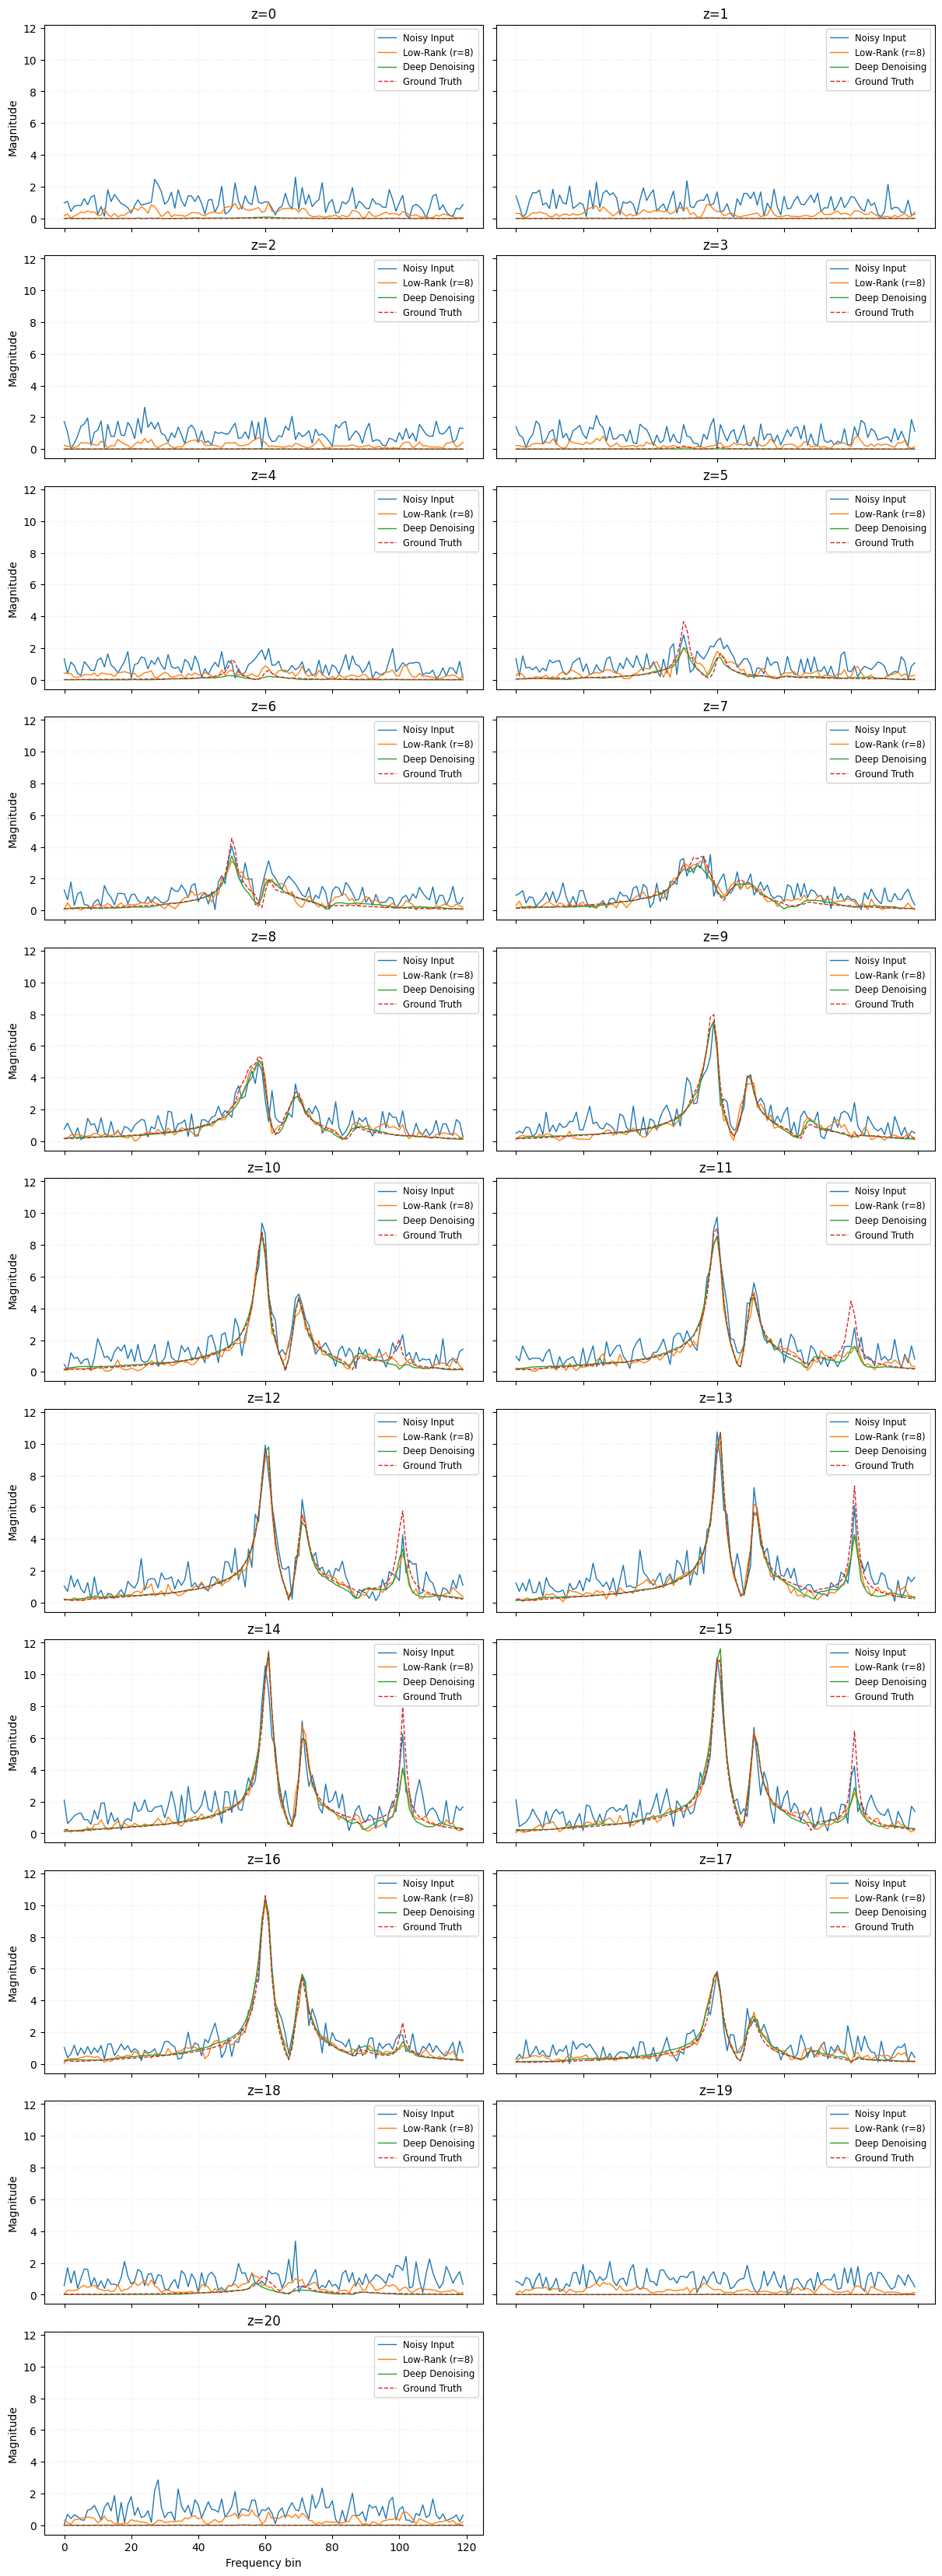

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ── FFT der Daten entlang der Zeitachse (axis=3) und Shift ────────────────────
spec_deep  = np.fft.fft(out_data,    axis=3); spec_deep  = np.fft.fftshift(spec_deep,  axes=3)
spec_lr    = np.fft.fft(baseline_data, axis=3); spec_lr    = np.fft.fftshift(spec_lr,    axes=3)
spec_in    = np.fft.fft(tgt_data,     axis=3); spec_in    = np.fft.fftshift(spec_in,    axes=3)
spec_noisy = np.fft.fft(noisy_data,   axis=3); spec_noisy = np.fft.fftshift(spec_noisy, axes=3)

# ── Plot-Konfiguration ─────────────────────────────────────────────────────
x, y, T = 9, 10, 7
Z       = spec_noisy.shape[2]    # Anzahl der z-Slices (hier 21)
F       = spec_noisy.shape[3]    # Anzahl der Frequenz-Bins
freqs   = np.arange(F)
rank    = 8                      # Rang für Low-Rank

n_cols  = 2
n_rows  = int(np.ceil(Z / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, n_rows * 3),
    sharex=True, sharey=True,
    constrained_layout=True
)

for z in range(Z):
    i, j = divmod(z, n_cols)
    ax = axes[i, j]

    # Magnituden extrahieren
    mag_in    = np.abs(spec_in   [x, y, z, :, T])
    mag_noisy = np.abs(spec_noisy[x, y, z, :, T])
    mag_lr    = np.abs(spec_lr   [x, y, z, :, T])
    mag_deep  = np.abs(spec_deep [x, y, z, :, T])

    # vier Kurven
    ax.plot(freqs, mag_noisy, '-', label='Noisy Input',        linewidth=1)
    ax.plot(freqs, mag_lr,    '-', label=f'Low-Rank (r={rank})', linewidth=1)
    ax.plot(freqs, mag_deep,  '-', label='Deep Denoising',     linewidth=1)
    ax.plot(freqs, mag_in,    '--', label='Ground Truth',      linewidth=1)

    ax.set_title(f"z={z}")
    ax.grid(True, linestyle=':', alpha=0.3)

    # Legende pro Subplot
    ax.legend(fontsize='small', loc='upper right')

    # Achsenbeschriftungen nur an den Rändern
    if i == n_rows - 1:
        ax.set_xlabel("Frequency bin")
    if j == 0:
        ax.set_ylabel("Magnitude")

# Leere Subplots ausblenden (falls Z ungerade)
for idx in range(Z, n_rows * n_cols):
    i, j = divmod(idx, n_cols)
    axes[i, j].axis('off')

plt.show()



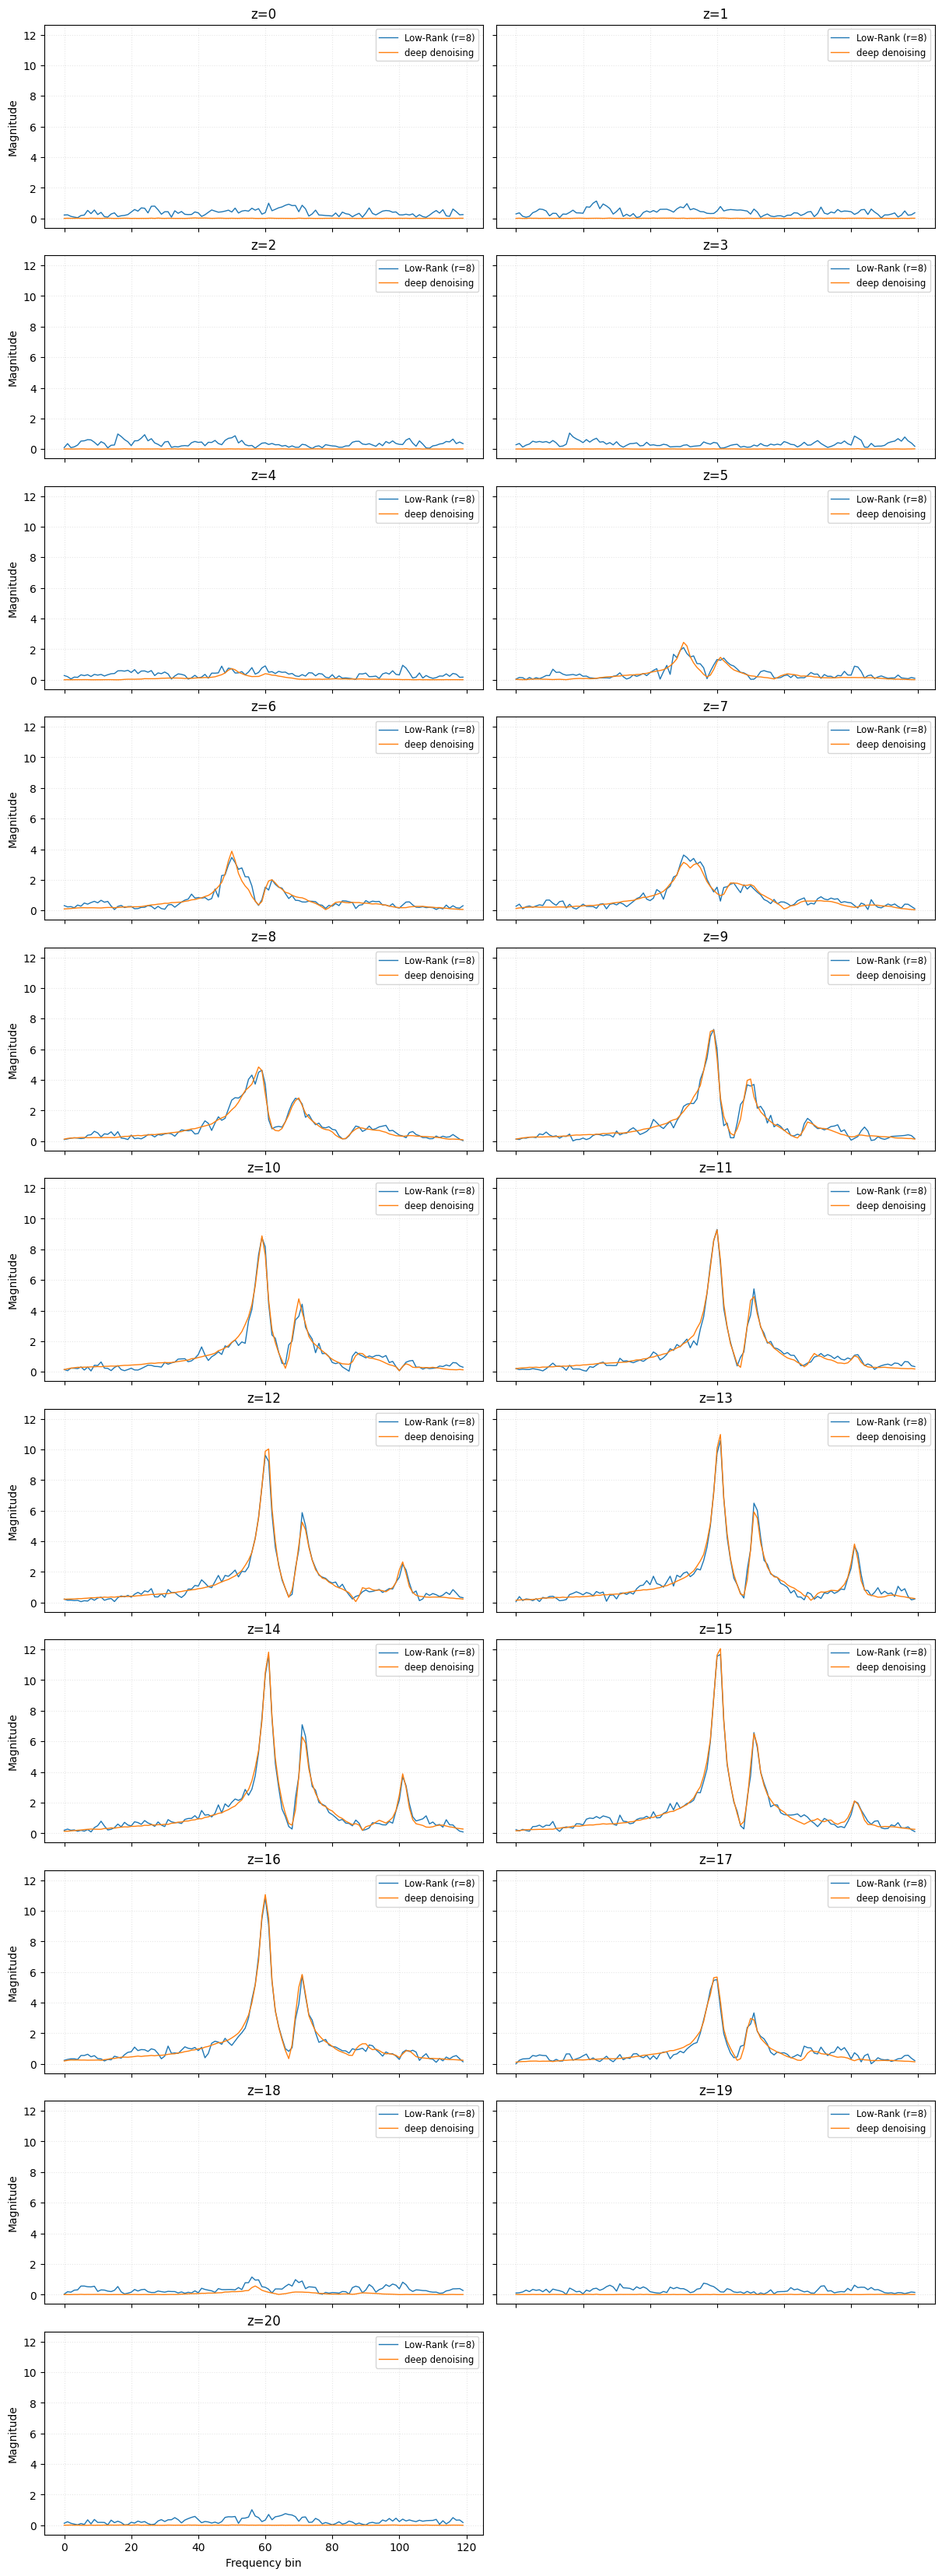

In [8]:
x,y,T = 10, 10, 0

# 2a) Deep-Denoising Spektrum
spec_deep = np.fft.fft(out_data, axis=3)
spec_deep = np.fft.fftshift(spec_deep, axes=3)

# 2b) Noisy Input Spektrum
spec_noisy = np.fft.fft(noisy_data, axis=3)
spec_noisy = np.fft.fftshift(spec_noisy, axes=3)

# 2c) Low-Rank Baseline Spektrum
spec_lr = np.fft.fft(baseline_data, axis=3)
spec_lr = np.fft.fftshift(spec_lr, axes=3)

# ── 21 Spektren für z=0…20 in einem 5×5-Grid plotten ─────────────────────────

# ── 21 Spektren (Noisy vs. Low-Rank vs. Noise2Void) in 2 Spalten ────────────

# ── 21 Spektren in 2 Spalten mit eigener Legende pro Plot und größerer Figure ──

import numpy as np
import matplotlib.pyplot as plt

# Parameter
x, y, T = 10, 10, 7
Z       = spec_noisy.shape[2]   # Anzahl der z-Slices (hier 21)
F       = spec_noisy.shape[3]   # Anzahl der Frequenz-Bins
freqs   = np.arange(F)
rank    = 8                     # Rang für Low-Rank

# Grid-Layout: 2 Spalten, genug Zeilen
n_cols  = 2
n_rows  = int(np.ceil(Z / n_cols))

# Figure größer machen: Breite × Höhe in Zoll
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, n_rows * 3),
    sharex=True, sharey=True,
    constrained_layout=True
)

for z in range(Z):
    i, j = divmod(z, n_cols)
    ax = axes[i, j]

    # Magnituden extrahieren
    mag_noisy = np.abs(spec_noisy[x, y, z, :, T])
    mag_lr    = np.abs(spec_lr   [x, y, z, :, T])
    mag_deep  = np.abs(spec_deep [x, y, z, :, T])

    # Plots
    ax.plot(freqs, mag_lr,    '-', label=f'Low-Rank (r={rank_post})', linewidth=1)
    ax.plot(freqs, mag_deep,  '-',  label=f'deep denoising', linewidth=1)

    ax.set_title(f"z={z}")
    ax.grid(True, linestyle=':', alpha=0.3)

    # Legende für jeden Subplot
    ax.legend(fontsize='small', loc='upper right')

    # Achsenbeschriftungen nur außen
    if i == n_rows - 1:
        ax.set_xlabel("Frequency bin")
    if j == 0:
        ax.set_ylabel("Magnitude")

# Leere Subplots ausblenden
for idx in range(Z, n_rows * n_cols):
    i, j = divmod(idx, n_cols)
    axes[i, j].axis('off')

#plt.savefig("spectra.png", dpi=300)
plt.show()

# Residuals to full dank noisy data

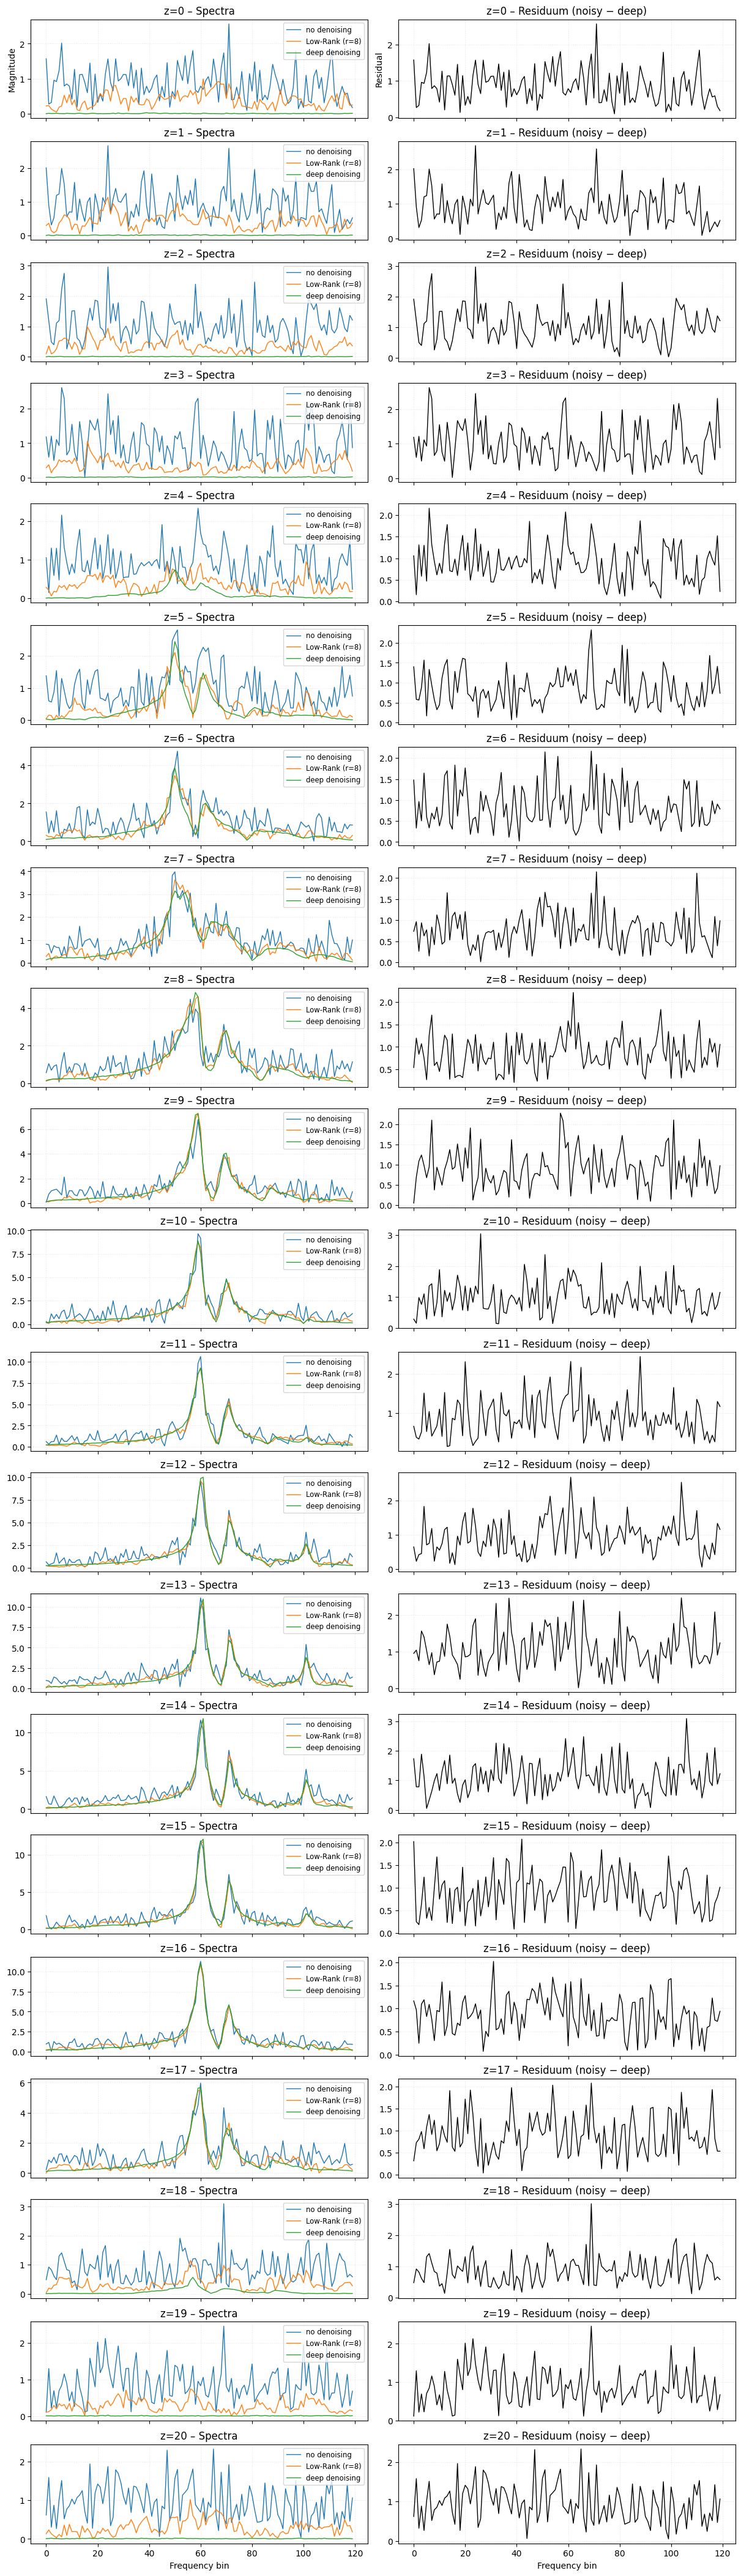

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
x, y, T = 10, 10, 7
Z       = spec_noisy.shape[2]   # Anzahl der z-Slices (z=0...20)
F       = spec_noisy.shape[3]   # Frequenz-Bins
freqs   = np.arange(F)
rank    = 8                     # Rang für Low-Rank

# Grid-Layout: 2 Spalten (Spektrum + Residuum), viele Zeilen
n_cols  = 2
n_rows  = Z

# Figure: größere Höhe, weil mehr Zeilen
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, n_rows * 2),
    sharex=True, constrained_layout=True
)

for z in range(Z):
    ax_spec = axes[z, 0]
    ax_res  = axes[z, 1]

    # Magnituden extrahieren
    mag_noisy = np.abs(spec_noisy[x, y, z, :, T])
    mag_lr    = np.abs(spec_lr   [x, y, z, :, T])
    mag_deep  = np.abs(spec_deep [x, y, z, :, T])
    resid     = np.abs(spec_noisy[x, y, z, :, T] - spec_deep [x, y, z, :, T])

    # Spektrenplot
    ax_spec.plot(freqs, mag_noisy, '-', label='no denoising', linewidth=1)
    ax_spec.plot(freqs, mag_lr,    '-', label=f'Low-Rank (r={rank})', linewidth=1)
    ax_spec.plot(freqs, mag_deep,  '-', label=f'deep denoising', linewidth=1)
    ax_spec.set_title(f"z={z} – Spectra")
    ax_spec.grid(True, linestyle=':', alpha=0.3)
    ax_spec.legend(fontsize='small', loc='upper right')

    # Residuenplot
    ax_res.plot(freqs, resid, '-', color='black', linewidth=1)
    ax_res.set_title(f"z={z} – Residuum (noisy − deep)")
    ax_res.grid(True, linestyle=':', alpha=0.3)

    # Achsenbeschriftungen
    if z == n_rows - 1:
        ax_spec.set_xlabel("Frequency bin")
        ax_res.set_xlabel("Frequency bin")
    if z == 0:
        ax_spec.set_ylabel("Magnitude")
        ax_res.set_ylabel("Residual")

#plt.savefig("spectra_and_residuals.png", dpi=300)
plt.show()

# Low rank on residual test:

# Compare spectral peaks

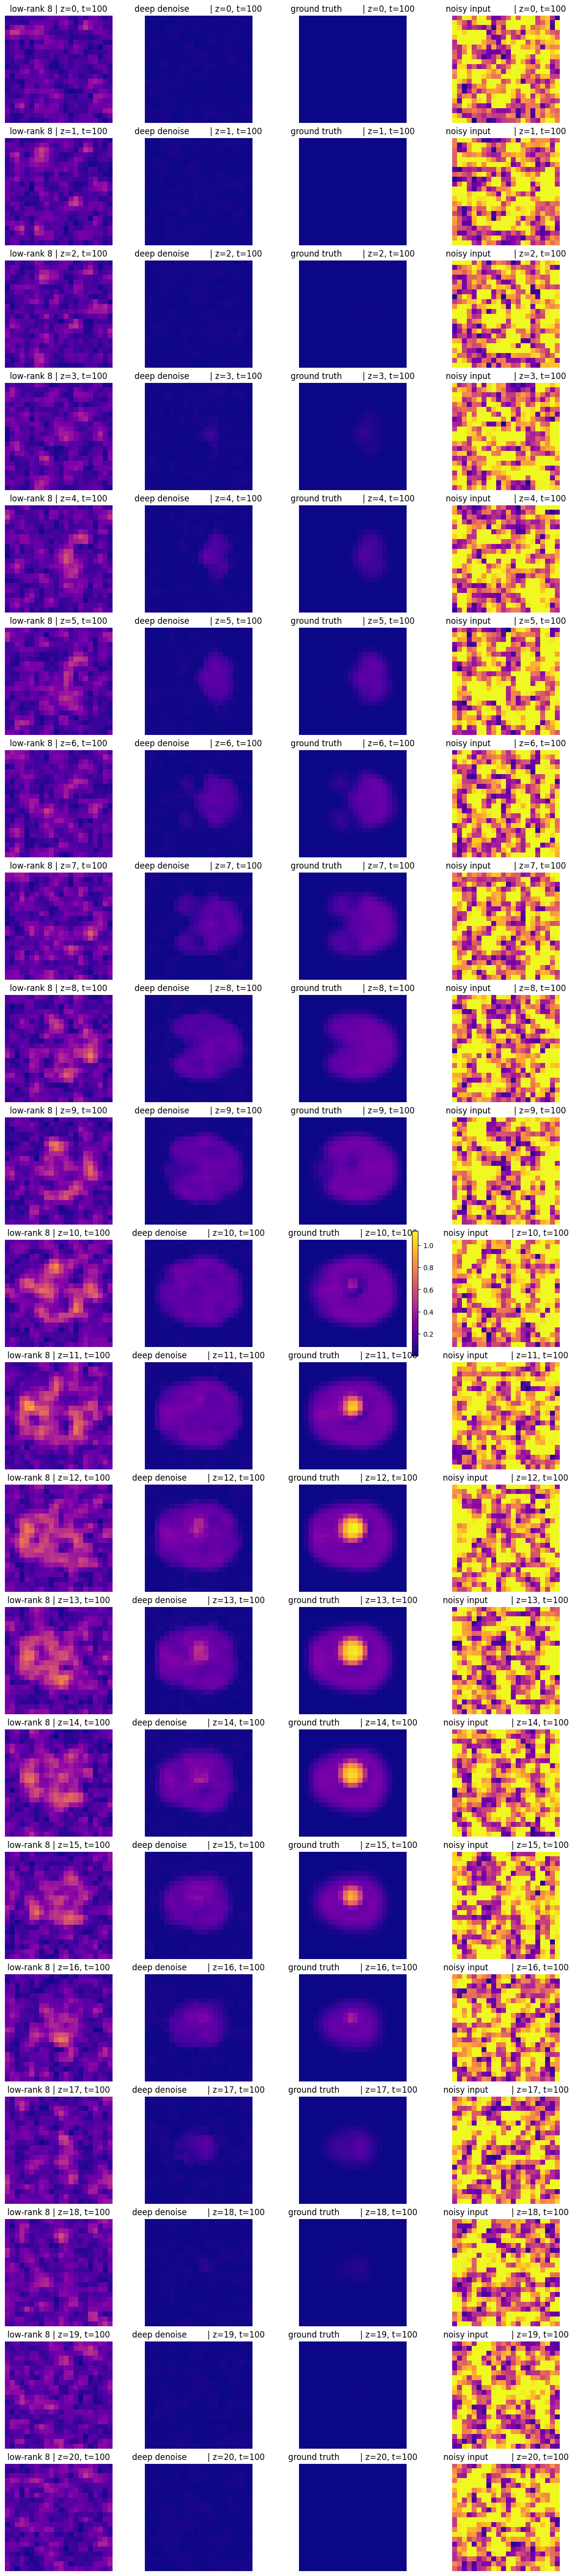

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# ── Einstellungen -----------------------------------------------------------
t, T = 100, 0
n_slices = out_data_ft.shape[2]

# ── 1) globales vmin/vmax nur aus der vorletzten Spalte (sl_in) berechnen ───
all_in = np.abs(tgt_data_ft[:, :, :, t, T])
vmin = all_in.min()
vmax = all_in.max()

# ── 2) Figure mit 4 Spalten ────────────────────────────────────────────────
fig, axes = plt.subplots(
    n_slices, 4,
    figsize=(12, n_slices * 2.5),
    constrained_layout=True
)

for z in range(n_slices):
    # Slice‑Magnituden
    sl_lr    = np.abs(baseline_data_ft[:, :, z, t, T])
    sl_deep  = np.abs(out_data_ft     [:, :, z, t, T])
    sl_in    = np.abs(tgt_data_ft     [:, :, z, t, T])
    sl_noisy = np.abs(noisy_data_ft   [:, :, z, t, T])

    ax_lr, ax_deep, ax_in, ax_noisy = axes[z]

    im0 = ax_lr   .imshow(sl_lr,    cmap='plasma', vmin=vmin, vmax=vmax)
    im1 = ax_deep .imshow(sl_deep,  cmap='plasma', vmin=vmin, vmax=vmax)
    im2 = ax_in   .imshow(sl_in,    cmap='plasma', vmin=vmin, vmax=vmax)  # Referenz für Colorbar
    im3 = ax_noisy.imshow(sl_noisy, cmap='plasma', vmin=vmin, vmax=vmax)

    ax_lr   .set_title(f"low‑rank {rank_post} | z={z}, t={t}")
    ax_deep .set_title(f"deep denoise        | z={z}, t={t}")
    ax_in   .set_title(f"ground truth        | z={z}, t={t}")
    ax_noisy.set_title(f"noisy input         | z={z}, t={t}")

    for ax in (ax_lr, ax_deep, ax_in, ax_noisy):
        ax.axis('off')

# ── 3) Gemeinsame Colorbar, ausgerichtet an der vorletzten Spalte ─────────
fig.colorbar(im2, ax=axes[:, 2], fraction=0.046, pad=0.04)

plt.show()




# Compare average spectra
Here I compare the average spectrum over time (which is a high SNR estimate) for gey matter which matter and all matter

In [11]:
avg_out = np.mean(out_data_ft, axis=(0, 1, 2))

avg_lr = np.mean(baseline_data_ft, axis=(0, 1, 2))

avg_tgt = np.mean(tgt_data_ft, axis=(0, 1, 2))

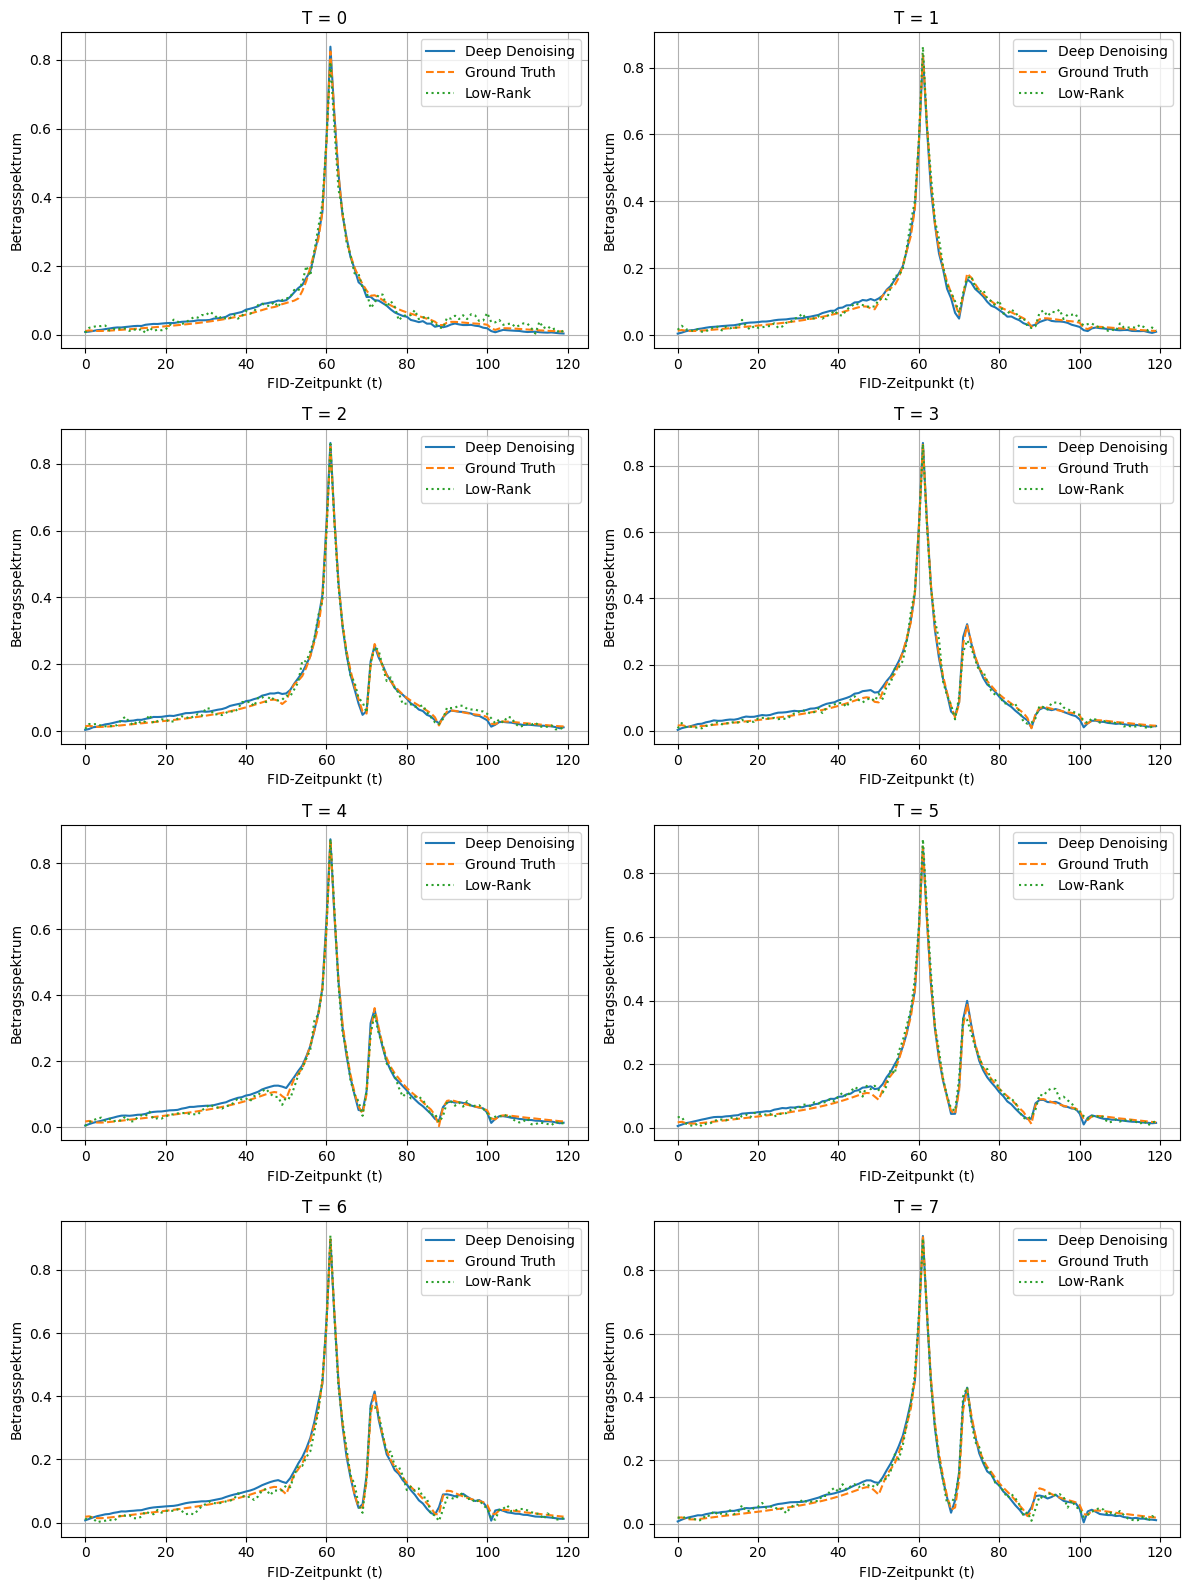

In [12]:
import matplotlib.pyplot as plt

# Subplot-Grid: 4 Zeilen × 2 Spalten für T = 0 bis 7
num_rows, num_cols = 4, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 16))

for idx, T in enumerate(range(8)):
    i = idx // num_cols
    j = idx % num_cols
    ax = axes[i, j]
    
    # Spektren extrahieren
    Line   = np.abs(avg_out)[:, T]
    Line_2 = np.abs(avg_tgt)[:, T]
    Line_3 = np.abs(avg_lr)[:, T]
    
    ax.plot(Line,   label="Deep Denoising")
    ax.plot(Line_2, linestyle="--", label="Ground Truth")
    ax.plot(Line_3, linestyle=":",  label="Low-Rank")
    
    ax.set_xlabel("FID-Zeitpunkt (t)")
    ax.set_ylabel("Betragsspektrum")
    ax.set_title(f"T = {T}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [13]:
def low_rank_5d(data, rank):
    """
    Computes a low-rank decomposition of a tensor with shape (22, 22, 21, 96, 8)
    using truncated SVD.

    Args:
        data (np.ndarray): Numpy array of shape (x, y, z, t, T).
        rank (int): The number of singular values to keep (final rank).

    Returns:
        np.ndarray: The reconstructed tensor with rank 'rank'.
    """

    # Unpack dimensions
    x, y, z, t, T = data.shape
    
    # Reshape the 5D tensor into a 2D matrix of shape (x*y*z, t*T)
    # Use 'F' (Fortran) order to match MATLAB's column-major ordering
    reshaped_matrix = data.reshape((x * y * z * T, t), order='F')
    
    # Perform economy-size SVD (similar to MATLAB's "svd(..., 'econ')")
    U, singular_values, Vh = np.linalg.svd(reshaped_matrix, full_matrices=False)
    
    # Truncate the singular values to the desired rank
    k = min(rank, len(singular_values))  # safeguard: rank cannot exceed # of singular values
    singular_values_truncated = np.zeros_like(singular_values)
    singular_values_truncated[:k] = singular_values[:k]
    
    # Form the diagonal matrix of truncated singular values
    S_truncated = np.diag(singular_values_truncated)
    
    # Reconstruct the matrix using the truncated SVD components
    reconstructed_matrix = U @ S_truncated @ Vh
    
    # Reshape back to the original 5D shape, again using 'F' order
    reconstructed_tensor = reconstructed_matrix.reshape((x, y, z, t, T), order='F')
    
    return reconstructed_tensor

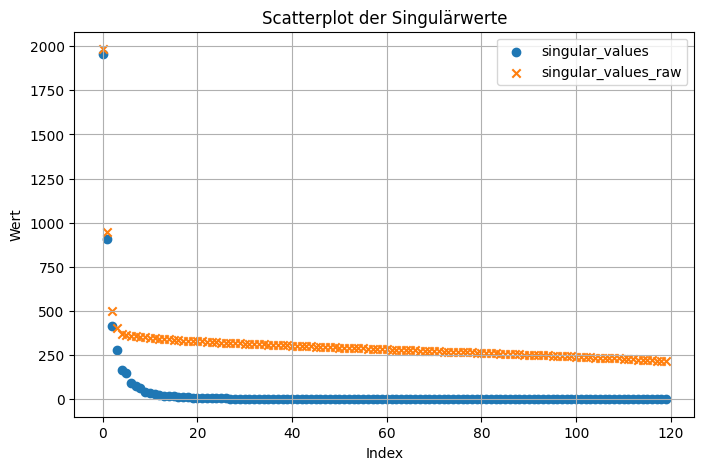

In [14]:
# Unpack dimensions
x, y, z, t, T = out_data.shape

# Reshape the 5D tensor into a 2D matrix of shape (x*y*z, t*T)
# Use 'F' (Fortran) order to match MATLAB's column-major ordering
reshaped_matrix = tgt_data_ft.reshape((x * y * z * T, t), order='F')

# Perform economy-size SVD (similar to MATLAB's "svd(..., 'econ')")
U, singular_values, Vh = np.linalg.svd(reshaped_matrix, full_matrices=False)

# Reshape the 5D tensor into a 2D matrix of shape (x*y*z, t*T)
# Use 'F' (Fortran) order to match MATLAB's column-major ordering
reshaped_matrix_raw = noisy_data_ft.reshape((x * y * z * T, t), order='F')

# Perform economy-size SVD (similar to MATLAB's "svd(..., 'econ')")
U, singular_values_raw, Vh = np.linalg.svd(reshaped_matrix_raw, full_matrices=False)

# Scatterplot
plt.figure(figsize=(8, 5))
plt.scatter(range(len(singular_values)), singular_values, 
            marker='o', label='singular_values')
plt.scatter(range(len(singular_values_raw)), singular_values_raw, 
            marker='x', label='singular_values_raw')

plt.xlabel('Index')
plt.ylabel('Wert')
plt.title('Scatterplot der Singulärwerte')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
singular_values

array([1.95289553e+03, 9.07409730e+02, 4.16316615e+02, 2.78383293e+02,
       1.67321062e+02, 1.48561030e+02, 9.22855983e+01, 7.26903483e+01,
       6.35035642e+01, 3.91662460e+01, 3.77957329e+01, 3.01097008e+01,
       2.57647913e+01, 2.03679652e+01, 1.80748126e+01, 1.55988277e+01,
       1.34918003e+01, 1.10611904e+01, 9.78517487e+00, 9.48772892e+00,
       8.03763064e+00, 7.42572102e+00, 6.86797684e+00, 6.43155996e+00,
       5.89732458e+00, 5.15652248e+00, 4.48579887e+00, 4.06122934e+00,
       3.93921402e+00, 3.74285050e+00, 3.47201380e+00, 3.37604159e+00,
       3.12239897e+00, 2.83918717e+00, 2.58401216e+00, 2.36882100e+00,
       2.29467420e+00, 2.09896819e+00, 1.96164239e+00, 1.71400012e+00,
       1.60866734e+00, 1.46350308e+00, 1.23743774e+00, 1.17185136e+00,
       1.13641775e+00, 1.00681133e+00, 8.96782546e-01, 8.54367038e-01,
       7.92839035e-01, 7.33738094e-01, 6.82457276e-01, 6.25840251e-01,
       5.88664759e-01, 5.20453585e-01, 5.07015266e-01, 4.69805105e-01,
      

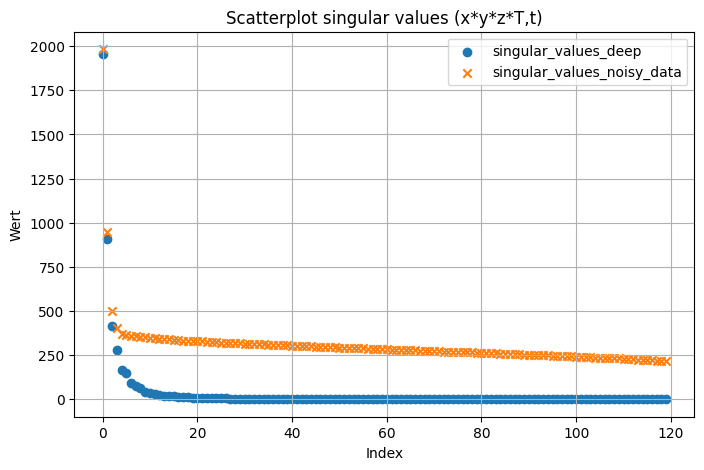

In [16]:
# Scatterplot
plt.figure(figsize=(8, 5))
plt.scatter(range(len(singular_values)), singular_values, 
            marker='o', label='singular_values_deep')
plt.scatter(range(len(singular_values_raw)), singular_values_raw, 
            marker='x', label='singular_values_noisy_data')

plt.xlabel('Index')
plt.ylabel('Wert')
plt.title('Scatterplot singular values (x*y*z*T,t)')
plt.legend()
plt.grid(True)
plt.show()